In [2]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def process_image_and_scale_centers(img, downsample_resolution=8, min_area=1000, max_area=50000, min_hole_area=100000, num_skeleton_points=10):
    """
    Downsamples an input image, applies a multi-step segmentation and filtering 
    pipeline (Otsu's thresholding, connected component analysis, noise removal, 
    hole filling, and skeletonization) to find the center points of blobs, 
    and then scales the center coordinates back to the original image resolution.

    Args:
        img (np.array): The input BGR image (original size).
        downsample_resolution (int): Factor by which to reduce the image size. 
                                        e.g., 8 means 1/8th the size.
        min_area (int): Minimum pixel area for a black blob to be considered a worm.
        max_area (int): Maximum pixel area for a black blob (to exclude background artifacts).
        min_hole_area (int): Maximum pixel area for a white region to be considered a 
                                'hole' and filled with black.
        num_skeleton_points (int): Number of skeleton points to sample per blob.

    Returns:
        list: A list of tuples, where each tuple contains (cx, cy) center coordinates 
                scaled to the original image resolution.
    """
    
    # 1. Downsample the image
    original_height, original_width = img.shape[:2]
    new_width = original_width // downsample_resolution
    new_height = original_height // downsample_resolution
    
    downsampled_img = cv2.resize(img, (new_width, new_height))
    
    print("Original image shape:", img.shape)
    print("Downsampled image shape:", downsampled_img.shape)

    # 2. Convert to grayscale and apply Gaussian blur
    if len(downsampled_img.shape) == 3:
        gray_img = cv2.cvtColor(downsampled_img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = downsampled_img

    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # 3. Otsu's thresholding
    _, initial_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4. Filter out small and large black blobs (noise/broken worms/background)
    inv_mask = 255 - initial_mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inv_mask, connectivity=8)

    filtered_mask = initial_mask.copy()
    
    for i in range(1, num_labels):  # Skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Filter out small blobs (noise/broken worms)
        if area < min_area:
            filtered_mask[labels == i] = 255  # Set to white
        
        # Filter out huge blobs (large background artifacts)
        elif area > max_area:
            filtered_mask[labels == i] = 255  # Set to white

    # 5. Fill small white holes in the remaining black blobs
    filled_mask = filtered_mask.copy()
    num_labels_white, labels_white, stats_white, centroids_white = cv2.connectedComponentsWithStats(filled_mask, connectivity=8)
    
    for i in range(1, num_labels_white):
        if stats_white[i, cv2.CC_STAT_AREA] < min_hole_area:
            filled_mask[labels_white == i] = 0  # Fill with black

    # 6. Find centers using skeletonization
    mask = filled_mask
    num_labels_blobs, labels_blobs, stats_blobs, centroids_blobs = cv2.connectedComponentsWithStats(255 - mask, connectivity=8)
    blob_centers = []
    
    for i in range(1, num_labels_blobs):
        area = stats_blobs[i, cv2.CC_STAT_AREA]
        
        if area >= min_area:
            blob_mask = (labels_blobs == i).astype(np.uint8)
            
            # Use skeletonization to find skeleton points
            skeleton = skeletonize(blob_mask)
            skeleton_points = np.where(skeleton)
            
            if len(skeleton_points[0]) > 0:
                # Collect all skeleton points as (cx, cy) tuples
                all_points = [(skeleton_points[1][j], skeleton_points[0][j]) for j in range(len(skeleton_points[0]))]
                
                # Select num_skeleton_points evenly spaced points
                N = len(all_points)
                if N <= num_skeleton_points:
                    blob_skeleton_points = all_points
                else:
                    indices = np.linspace(0, N-1, num_skeleton_points, dtype=int)
                    blob_skeleton_points = [all_points[j] for j in indices]
                
                blob_centers.append(blob_skeleton_points)

    # 7. Scale the skeleton points back to the original image coordinates
    scaled_blob_centers = []
    for blob_points in blob_centers:
        scaled_points = [(int(cx * downsample_resolution), int(cy * downsample_resolution)) for cx, cy in blob_points]
        scaled_blob_centers.append(scaled_points)

    return scaled_blob_centers


In [3]:
# select the device for computation
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [4]:
# `video_dir` a directory of PNG frames with filenames like `<frame_index>.png`
import cv2
import os
import matplotlib.pyplot as plt
video_dir = "small_thumbnails_downsampled"
frame_idx = 0
img = cv2.imread(os.path.join(video_dir, f"{frame_idx}.jpg"))
scaled_blob_centers = process_image_and_scale_centers(img, downsample_resolution=1, num_skeleton_points=10)
print("Scaled blob centers (original image coordinates):", scaled_blob_centers)

Original image shape: (466, 936, 3)
Downsampled image shape: (466, 936, 3)
Scaled blob centers (original image coordinates): [[(452, 132), (458, 135), (351, 143), (424, 143), (420, 144), (324, 149), (318, 162), (296, 189), (247, 199), (265, 202)], [(408, 164), (430, 168), (461, 174), (488, 183), (507, 191), (453, 196), (528, 201), (560, 210), (594, 223), (629, 245)], [(804, 180), (835, 188), (784, 190), (821, 191), (834, 197), (851, 206), (861, 222), (872, 229), (868, 239), (877, 254)], [(347, 226), (317, 229), (322, 230), (308, 232), (304, 238), (306, 242), (291, 246), (277, 252), (272, 259), (258, 267)], [(370, 245), (378, 260), (461, 263), (448, 265), (362, 278), (330, 303), (293, 316), (266, 328), (237, 349), (219, 385)], [(744, 254), (729, 263), (725, 265), (740, 267), (735, 274), (723, 283), (715, 285), (707, 286), (695, 287), (706, 287)], [(201, 273), (201, 286), (196, 300), (188, 314), (181, 327), (174, 341), (170, 355), (167, 368), (162, 382), (153, 395)], [(621, 277), (606, 2

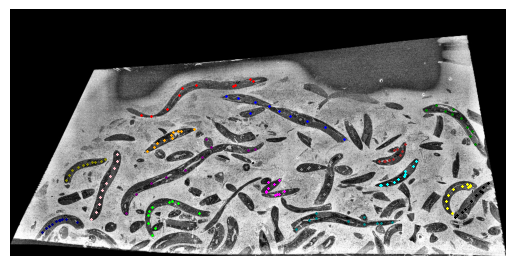

In [5]:
plt.imshow(img)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'black', 'lime', 'teal', 'navy']
for i, skeleton_pts in enumerate(scaled_blob_centers):
    for cx, cy in skeleton_pts:
        plt.scatter(cx, cy, color=colors[i % len(colors)], marker='x', s=1)
plt.axis('off')
plt.show()

In [6]:
from sam2.build_sam import build_sam2_video_predictor
model_size = "base"
if model_size == "tiny":
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_tiny.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
elif model_size == "base":
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_base_plus.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
elif model_size == "large":
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
else:
    raise ValueError(f"Unknown model size: {model_size}")

print(f"using model {model_size}")
print(f"Sam2 checkpoint: {sam2_checkpoint}")
print(f"Sam2 modelconfig: {model_cfg}")

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
inference_state = predictor.init_state(video_path=video_dir)

using model base
Sam2 checkpoint: ./checkpoints/sam2.1_hiera_base_plus.pt
Sam2 modelconfig: configs/sam2.1/sam2.1_hiera_b+.yaml


frame loading (JPEG): 100%|██████████| 11/11 [00:00<00:00, 39.93it/s]


In [7]:
ann_frame_idx = 0  # the frame index we interact with

num_objs_to_track = 2
for i, prompts in enumerate(scaled_blob_centers[:num_objs_to_track]):
    ann_obj_id = i + 1  # give a unique id to each object we interact with (it can be any integers)
    
    # Use each center as a separate point for a separate object
    points = np.array(prompts, dtype=np.float32)  # for labels, `1` means positive click and `0` means negative click
    labels = np.ones(points.shape[0], dtype=np.int32)
    
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )

/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


torch.Size([2, 1, 466, 936])


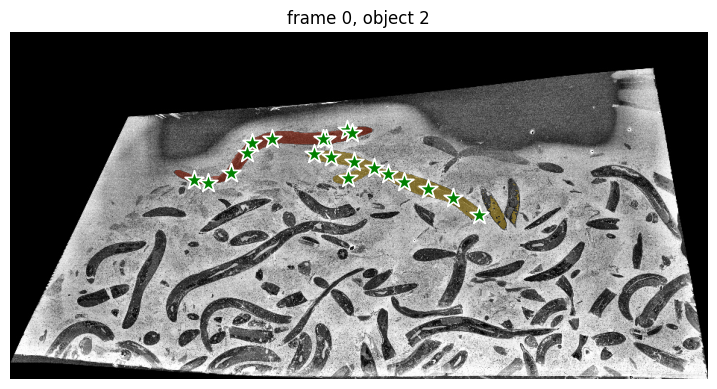

In [8]:
print(out_mask_logits.shape)  # (num_interacted_objects, H, W)
# combined_mask = (out_mask_logits > 0.0).any(dim=0).squeeze().cpu().numpy()
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}, object {ann_obj_id}")
plt.imshow(img)

for i, prompts in enumerate(scaled_blob_centers[:num_objs_to_track]):
    points = np.array(prompts, dtype=np.float32)  # for labels, `1` means positive click and `0` means negative click
    labels = np.ones(points.shape[0], dtype=np.int32)
    show_points(points, labels, plt.gca())
    mask = (out_mask_logits[i]>0.0).any(dim=0).squeeze().cpu().numpy()
    show_mask(mask, plt.gca(), obj_id=0, random_color=True)
plt.axis('off')
plt.show()


In [9]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 11/11 [00:25<00:00,  2.31s/it]


In [15]:
import cv2
import numpy as np
import os

# Assume the original undownsampled video frames are in a directory called "original_video_dir"
# with filenames like "<frame_index>.jpg" (adjust if different)
original_video_dir = "small_thumbnails_cropped"  # Update this path to your original video directory

# Determine the downsampling factor (based on the process_image_and_scale_centers function, default is 8, but in cell 2 it was set to 1; however, since images are downsampled, assume factor=8)
downsample_factor = 8  # Adjust if your downsampling factor is different

# Dictionary to store upscaled masks for the original video
original_video_segments = {}

# Get the number of frames from the existing video_segments
num_frames = len(video_segments)

for out_frame_idx in range(num_frames):
    # Load the original frame to get its dimensions
    original_img_path = os.path.join(original_video_dir, f"{out_frame_idx}.jpg")
    if not os.path.exists(original_img_path):
        print(f"Original frame {out_frame_idx} not found at {original_img_path}")
        continue
    original_img = cv2.imread(original_img_path)
    original_height, original_width = original_img.shape[:2]
    
    # Initialize the frame's segments
    original_video_segments[out_frame_idx] = {}
    
    for out_obj_id, mask in video_segments[out_frame_idx].items():
        # The mask is a numpy array of shape (1, H_downsampled, W_downsampled)
        mask_downsampled = mask.squeeze()  # Shape: (H_downsampled, W_downsampled)
        
        # Upscale the mask to original resolution using nearest neighbor interpolation
        # Convert to uint8 for cv2.resize, then back to bool
        mask_upscaled = cv2.resize(
            (mask_downsampled * 255).astype(np.uint8),
            (original_width, original_height),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)
        
        # Store the upscaled mask
        original_video_segments[out_frame_idx][out_obj_id] = mask_upscaled

# Now original_video_segments contains the masks for the original resolution video
# You can use this similarly to video_segments for further processing, e.g., rendering or saving

In [17]:
import cv2
import os
import tempfile
from PIL import Image

def render_segmentation_video(video_segments, video_dir, output_video_path, fps=5):
    num_frames = len(video_segments)
    frame_images = []
    
    # Create a temporary directory to store frame images
    temp_dir = tempfile.mkdtemp()
    
    for out_frame_idx in range(num_frames):
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, f"{out_frame_idx}.jpg")))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.axis('off')
        
        # Save the figure as an image
        frame_path = os.path.join(temp_dir, f"frame_{out_frame_idx:04d}.png")
        plt.savefig(frame_path)
        plt.close()
        frame_images.append(frame_path)
    
    # Now create the MP4 video from the saved images
    frame = cv2.imread(frame_images[0])
    height, width, layers = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    for image_path in frame_images:
        video.write(cv2.imread(image_path))
    
    video.release()
    
    # Clean up temporary images
    for image_path in frame_images:
        os.remove(image_path)
    os.rmdir(temp_dir)
    
    print(f"Video saved as {output_video_path}")

# Call the function with existing variables
render_segmentation_video(video_segments, video_dir, "segmentation_results_nov25.mp4")

Video saved as segmentation_results_nov25.mp4


In [18]:
render_segmentation_video(original_video_segments, original_video_dir, "upsampled_segmentation_results_nov25.mp4")

Video saved as upsampled_segmentation_results_nov25.mp4


/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


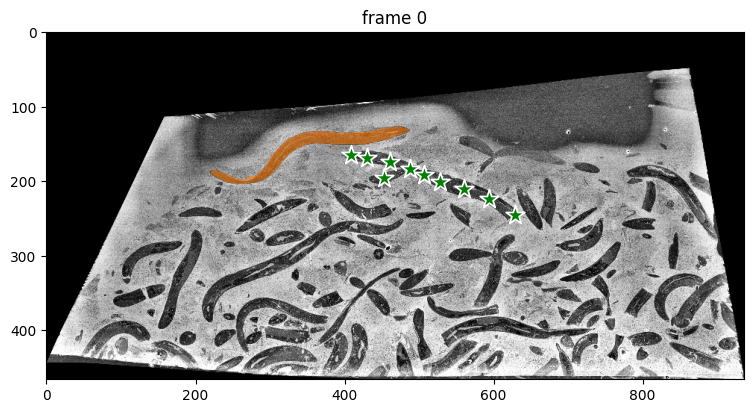

In [13]:
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
from PIL import Image
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, f"{ann_frame_idx}.jpg")))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])